# Retweet Networks and Community Clusters

## Objective

## Tools/ Technology Used

* **Pandas** create undirected weighted graphs for retweet network
* **GraphFrames** Spark library to detect Community Clusters using LPA( Label Propagation Algorithm) and find influencers using PageRank
* **Seaborn** Visualize cluster strength through bar chart
* **Gephi** Compute community clusters using modularity and find influencers through betweenness centrality and Eigenvector centrality

## Import the necessary packages

In [80]:
import sys
import pandas as pd
import numpy as np
import re
import os

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('retweet graph').getOrCreate()
sc = spark.sparkContext

import warnings
warnings.filterwarnings('ignore')

## Read and Preprocess Data

We read the records that were retwitted from Humans.csv, the input file for this analysis, which was generated after discarding the fake accounts('') and cleaning the tweets with standard NLP techniques(''). We grab the users by their screen_names if they have retweeted (given by the boolian value of is_retweet column) and we also take the post that they have retwitted given by the column text_retweet.Then we apply the following preprocessing steps:
* *Filter out records if they are NAN*
* *Add a new column retweet_username to the dataframe which captures the user who had posted the tweet for the first time*



In [52]:
# Filter out records if they are NAN
def isNaN(num):
    return num != num

In [53]:
# Read input file and get the retweeted records in dataframe retweet_df
read_df = pd.read_csv('humans1.csv', sep=';', index_col='id', usecols = ['id', 'screen_name', 'is_retweet', 'text_retweet'])
retweet_df = read_df[read_df.apply(lambda x: (x['is_retweet']==True) and (isNaN(x['text_retweet'])==False), axis=1)]
retweet_df = retweet_df.reset_index()
retweet_df.head(3)

,id,is_retweet,text_retweet,screen_name
0,40000,True,"RT @jdesmondharris: You don't have to write ""i...",SamanthaCorbin
1,40002,True,"RT @jdesmondharris: You don't have to write ""i...",dinosaur_m
2,40003,True,RT @TheUSASingers: Here it is folks!\n\nWe are...,CloeNana


In [54]:
# Append the screen_name of the original post that has been retweeted
def get_retweet_user(text_retweet):
    try:
        return re.match(r"RT @(\S+):.*", text_retweet).group(1)
    except:
        return 'False'
    
retweet_df['retweet_username'] = retweet_df.apply(lambda x: get_retweet_user(x['text_retweet']), axis=1)
retweet_df = retweet_df.reset_index()

# Print the final input dataframe
retweet_df.head(3)

,index,id,is_retweet,text_retweet,screen_name,retweet_username
0,0,40000,True,"RT @jdesmondharris: You don't have to write ""i...",SamanthaCorbin,jdesmondharris
1,1,40002,True,"RT @jdesmondharris: You don't have to write ""i...",dinosaur_m,jdesmondharris
2,2,40003,True,RT @TheUSASingers: Here it is folks!\n\nWe are...,CloeNana,TheUSASingers


## Create Retweet graphs and store it as text file

We construct the weighted undirected graph to form the retweet network by defining the parent-child relationships between the users such that everytime an user (given by field screen_name) retweets another user's post (given by the field 'retweet_username') we draw an edge between them and the number of times they have communicated or retweeted each other becomes the edge weight. In order to reduce clutter in the network we however filter out nodes or users who have communicated less than 5 times. This parameter can be configured as per the analyst's need.  

In [55]:
def retweetgraph(data, filename, num = 5):
    
    #append all users to a list
    retweets = []
    for line in data:
        retweets.append([line[0], line[1], line[2], line[3]])
        
    # Define nodes
    nodes = dict()
    for line in retweets:
        if line[0] not in nodes:
            nodes[line[0]] = 0
        nodes[line[0]] += 1
        if line[1] not in nodes:
            nodes[line[1]] = 0
        nodes[line[1]] += 1

    # Filter nodes with more than 'num' weighted degree    
    for i in list(nodes):
        if nodes[i] <= num:
            del nodes[i]
            
    # Define undirected weighted edges without self loop
    temp = dict()
    for retweet in retweets:
        if retweet[0] == retweet[1]:
            continue
        if retweet[0] in nodes and retweet[1] in nodes:
            if (retweet[0], retweet[1], retweet[2], retweet[3]) in temp:
                temp[(retweet[0], retweet[1], retweet[2], retweet[3])] += 1
            elif (retweet[1], retweet[0], retweet[3], retweet[2]) in temp:
                temp[(retweet[1], retweet[0], retweet[3], retweet[2])] += 1
            else:
                temp[(retweet[0], retweet[1], retweet[2], retweet[3])] = 1
    edges = list(temp.items())
    
    # Write the graph to a file
    f = open(filename, 'w')
    for edge in edges:
        f.write('{}\t{}\t{}\t{}\t{}\n'.format(edge[0][0], edge[0][1], edge[0][2], edge[0][3], edge[1]))
    f.close()

In [56]:
# give unique ids to the nodes
def hashnode(x):
    return int(hashlib.sha1(str.encode(x)).hexdigest(), 16) % (10 ** 8)
retweet_df['source'] = retweet_df.apply(lambda x: hashnode(x['screen_name']), axis=1)
retweet_df['target'] = retweet_df.apply(lambda x: hashnode(x['retweet_username']), axis=1)

# create the graph and save it as retweetgraph.txt
retweetgraph(retweet_df[retweet_df['retweet_username'] != 'False'][['source', 'target', 'screen_name', 'retweet_username']].values.tolist(), 'retweetgraph.txt', 2)

## Find communities and their influencers using GraphFrames Pyspark

GraphFrames is a package for Apache Spark that provides DataFrame-based graphs. We use Label Propagation Algorithm to cluster nodes to form communities and PageRank algorithm to find the main influencers of these communities. Using Pyspark we have written retweet_graph_lpa.py to implement these functionalities.

**Label Propagation Algorithm** is a semi-supervised machine learning algorithm well known for finding community structures within complex networks.At the start of the algorithm, a (generally small) subset of the data points have labels (or classifications). These labels are propagated to the unlabeled points throughout the course of the algorithm. LPA has advantages in its running time and amount of a priori information needed about the network structure (no parameter is required to be known beforehand), though it also has a disadvantage that it produces no unique solution, but an aggregate of many solutions.

**PageRank Algorithm** is used to calculate the centrality measure of nodes in each of the clusters defined by Label Propagation Algorithm. This allows us to get the nodes with high centrality. Intutively having high PageRank implies that the node or user is the main influencer in his community. Though PageRank gives better results for more number of iterations, we have executed it for 5 iterations to reduce execution time.

#### Note: Put graphframe jar file matching the pyspark version in current directory
spark-sumbit --packages graphframe:graphframes:<graphframe version> retweet_graph_lpa.py

In [63]:
!spark-submit --packages graphframes:graphframes:0.7.0-spark2.4-s_2.11 retweet_graph_lpa.py

Ivy Default Cache set to: /home/ipsita_proff/.ivy2/cache
The jars for the packages stored in: /home/ipsita_proff/.ivy2/jars
:: loading settings :: url = jar:file:/home/ipsita_proff/anaconda3/lib/python3.6/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ed31dbd0-38b6-4774-a63e-547db3297024;1.0
	confs: [default]
	found graphframes#graphframes;0.7.0-spark2.4-s_2.11 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 270ms :: artifacts dl 4ms
	:: modules in use:
	graphframes#graphframes;0.7.0-spark2.4-s_2.11 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnld

In [66]:
#Show first few rows of communities and their pageranks
sdf = spark.read.parquet('retweet_lpa.parquet')
print('First 10 records')
print('id=user, label=community number, pagerank=pagerank')
sdf.show(10)

First 10 records
id=user, label=community number, pagerank=pagerank
+--------+--------+--------------+------------------+
|      id|   label|          name|          pagerank|
+--------+--------+--------------+------------------+
|  848133| 1160370|    AfroKing84|0.7560688069877516|
| 1581751|27822384|    sjferg1252|0.5684727872088358|
| 2980232|99895617|   ThackDesign| 2.948152239854151|
| 6959729|41671098|EducatedNegro_|0.5684727872088358|
|11637265|99895617| laurathatsme1|0.7628515864542758|
|26372106|12663902|  jessphillips|0.5684727872088358|
|41558693|72179470|   smartasafox|3.1928097867020235|
|41852169|66326885|     masuruha2|0.5684727872088358|
|49119829| 5584557|  ramgopal2812|0.5684727872088358|
|49726859|58864876|  TakedownMRAs|0.8498668168772096|
+--------+--------+--------------+------------------+
only showing top 10 rows



## EDA with the Community Clusters

### Top 10 largest communities

In [78]:
label_cnt=sdf.groupby('label').count().sort('count', ascending=False).limit(10)
print("Top 10 largest communities")
label_cnt.show()


Top 10 largest communities
+--------+-----+
|   label|count|
+--------+-----+
|99895617|  211|
|  246824|   66|
| 5584557|   50|
|  563267|   40|
|69025752|   39|
| 7131802|   33|
|53561793|   26|
|65116894|   25|
|43973229|   19|
|95026042|   18|
+--------+-----+



### Main Influencers in these communities

In [85]:
df_maxrange = sdf.groupby('label').max('pagerank')
df_influencers = df_maxrange.join(label_cnt, ['label'])
print('Main Influencers of top 10 communities')
df_influencers.show()


Main Influencers of top 10 communities
+--------+------------------+-----+
|   label|     max(pagerank)|count|
+--------+------------------+-----+
| 5584557|1.5857825529674237|   50|
|99895617|18.272602756352352|  211|
|  246824|1.3309721005063475|   66|
|  563267|0.5684727872088358|   40|
|69025752|1.4098409359172734|   39|
|43973229|0.5684727872088358|   19|
|53561793|0.5684727872088358|   26|
|95026042|0.7560688069877516|   18|
|65116894|1.1312608465455833|   25|
| 7131802|12.542463375034618|   33|
+--------+------------------+-----+



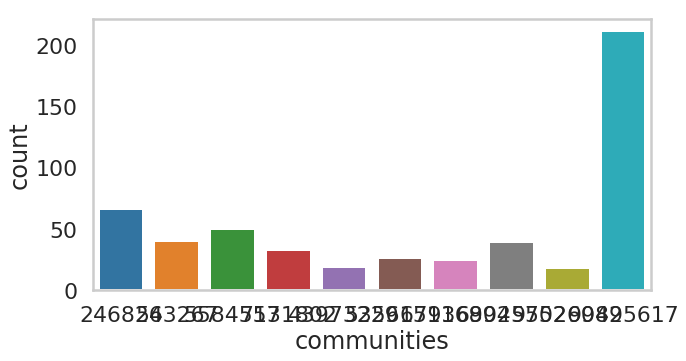

In [93]:
temp = df_influencers.collect()
columns=['label','influencer', 'count']
df = pd.DataFrame(temp, columns=columns)
df

# #Plot the topics
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x= "label", y = "count")
ax.set(xlabel = 'communities')
sns.set_context("poster")
plt.show()

## Visualize communities and their influencers by Gephi